In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read data
from darts.datasets import AirPassengersDataset

series = AirPassengersDataset().load()

In [3]:
# Split train & val
train, val = series.split_after(pd.Timestamp("19590101"))

In [4]:
# Normalize the data
from darts.dataprocessing.transformers import Scaler

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [5]:
# Create month and year covariate series
from darts.utils.timeseries_generation import datetime_attribute_timeseries

year_series = datetime_attribute_timeseries(
  pd.date_range(
    start=series.start_time(),
    freq=series.freq_str,
    periods=1000
  ),
  attribute="year",
  one_hot=False
)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
  year_series,
  attribute="month",
  one_hot=True
)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("19590101"))

In [6]:
# Create the model
from darts.models import RNNModel

lstm_model = RNNModel(
  model="LSTM",
  n_epochs=300,
  n_rnn_layers=1,
  hidden_dim=20,
  input_chunk_length=14,
  training_length=20,
  dropout=0,
  batch_size=16,
  optimizer_kwargs={"lr": 1e-3},
  save_checkpoints=True,
  log_tensorboard=True,
  model_name="Air_RNN",
  force_reset=True,
  random_state=42
)

lstm_model.fit(
  train_transformed,
  future_covariates=covariates,
  val_series=val_transformed,
  val_future_covariates=covariates,
  verbose=True
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.9 K 
4 | V             | Linear           | 21    
-------------------------------

/usr/local/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 299: 100%|██████████| 7/7 [00:00<00:00, 25.04it/s, v_num=logs, train_loss=0.000237, val_loss=0.002]  

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 7/7 [00:00<00:00, 24.19it/s, v_num=logs, train_loss=0.000237, val_loss=0.002]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, n_epochs=300, input_chunk_length=14, batch_size=16, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, model_name=Air_RNN, force_reset=True, random_state=42)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.17it/s]


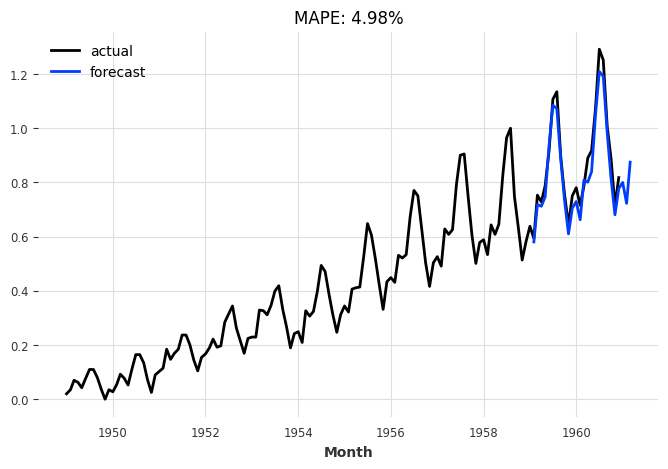

In [7]:
# Evaluate the model
from darts.metrics import mape

def eval_model(model):
  pred_series = model.predict(n=26, future_covariates=covariates)
  plt.figure(figsize=(8, 5))
  series_transformed.plot(label="actual")
  pred_series.plot(label="forecast")
  plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
  plt.legend()

eval_model(lstm_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.34it/s]


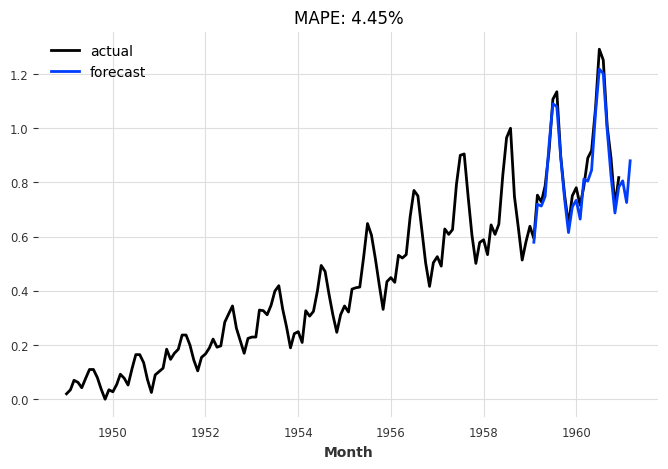

In [8]:
# ...vs the best model
best_model = RNNModel.load_from_checkpoint(model_name="Air_RNN", best=True)
eval_model(best_model)